In [356]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from darts import TimeSeries
from darts.models import Theta

import constants

plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1

In [357]:
def calc_mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [358]:
df = yf.download("KO", start="2009-01-01", end="2019-01-01")
df = df.asfreq('B', method='ffill')

[*********************100%%**********************]  1 of 1 completed


In [359]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2607.000000,2607.000000,2607.000000,2607.000000,2607.000000,2.607000e+03
mean,37.799486,38.035081,37.567988,37.811110,28.314951,1.567400e+07
std,6.945057,6.966439,6.931060,6.946541,7.269546,7.272947e+06
min,19.075001,19.605000,18.719999,18.924999,11.955875,2.996300e+06
25%,33.584999,33.750000,33.320000,33.500000,22.957000,1.096130e+07
50%,40.080002,40.340000,39.799999,40.080002,29.367643,1.406030e+07
75%,42.754999,43.080002,42.495001,42.764999,33.825272,1.845860e+07
max,50.820000,50.840000,50.250000,50.509998,43.459175,1.241690e+08


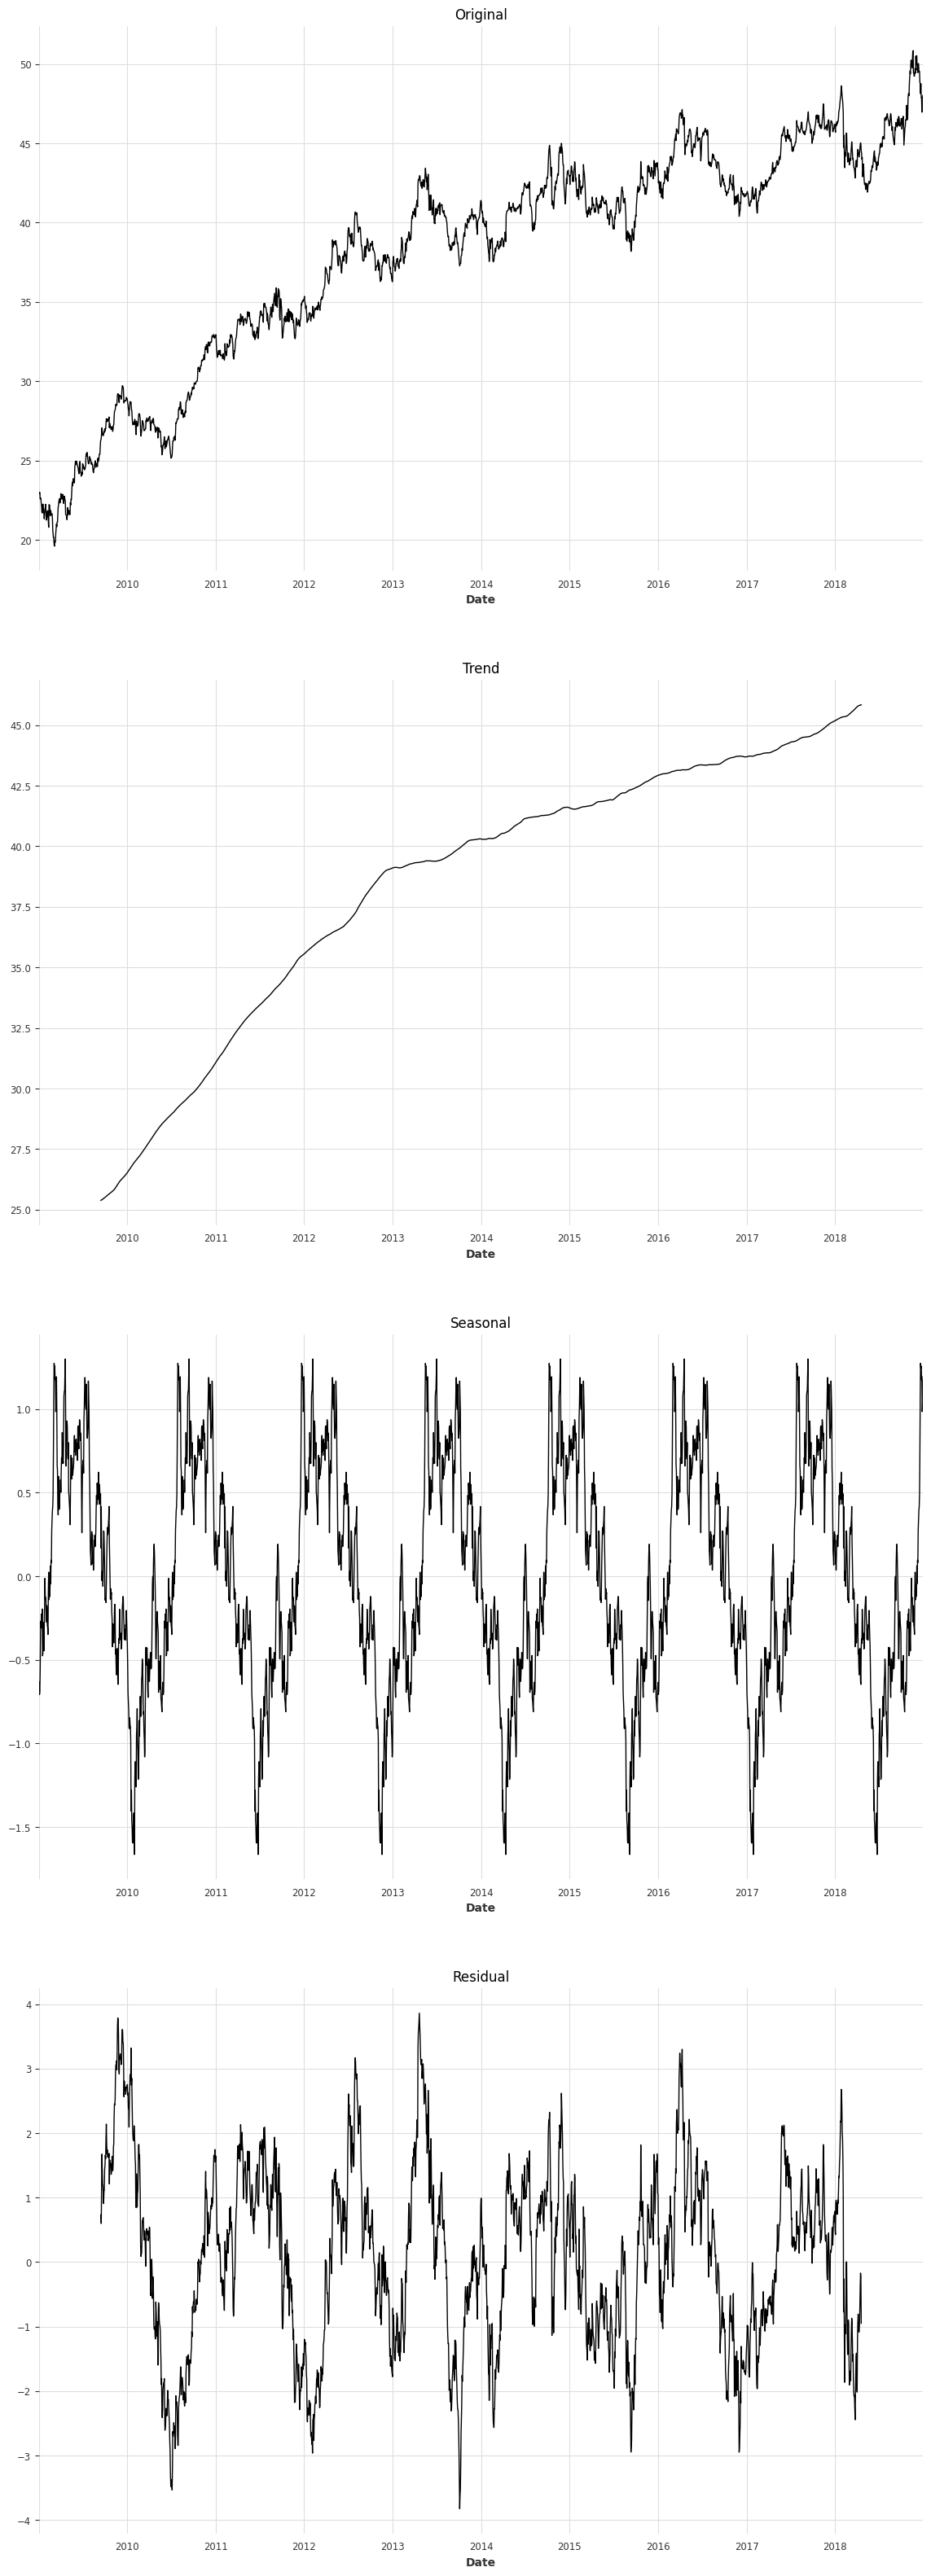

In [360]:
# Разложим ряд на компоненты и проверим ответы на вопросы

from statsmodels.tsa.seasonal import seasonal_decompose

_, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df[['High']], period=365)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [361]:
df['OpenDiff_1'] = df['Open'] - df['Open'].shift(1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,OpenDiff_1
Date,,,,,,,
2009-01-02,22.700001,23.000000,22.520000,22.950001,14.498669,16355800,NaN
2009-01-05,22.785000,22.945000,22.590000,22.719999,14.353368,20237200,0.084999
2009-01-06,22.850000,22.985001,22.230000,22.355000,14.122774,21307800,0.065001
2009-01-07,22.110001,22.590000,22.110001,22.465000,14.192268,21581000,-0.740000
2009-01-08,22.420000,22.639999,22.280001,22.620001,14.290196,20087000,0.309999


In [362]:
df['OpenLog'] = np.log(df['Open'])
df['OpenLogDiff_1'] = df['OpenLog'] - df['OpenLog'].shift(1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,OpenDiff_1,OpenLog,OpenLogDiff_1
Date,,,,,,,,,
2009-01-02,22.700001,23.000000,22.520000,22.950001,14.498669,16355800,NaN,3.122365,NaN
2009-01-05,22.785000,22.945000,22.590000,22.719999,14.353368,20237200,0.084999,3.126102,0.003737
2009-01-06,22.850000,22.985001,22.230000,22.355000,14.122774,21307800,0.065001,3.128951,0.002849
2009-01-07,22.110001,22.590000,22.110001,22.465000,14.192268,21581000,-0.740000,3.096030,-0.032921
2009-01-08,22.420000,22.639999,22.280001,22.620001,14.290196,20087000,0.309999,3.109953,0.013923


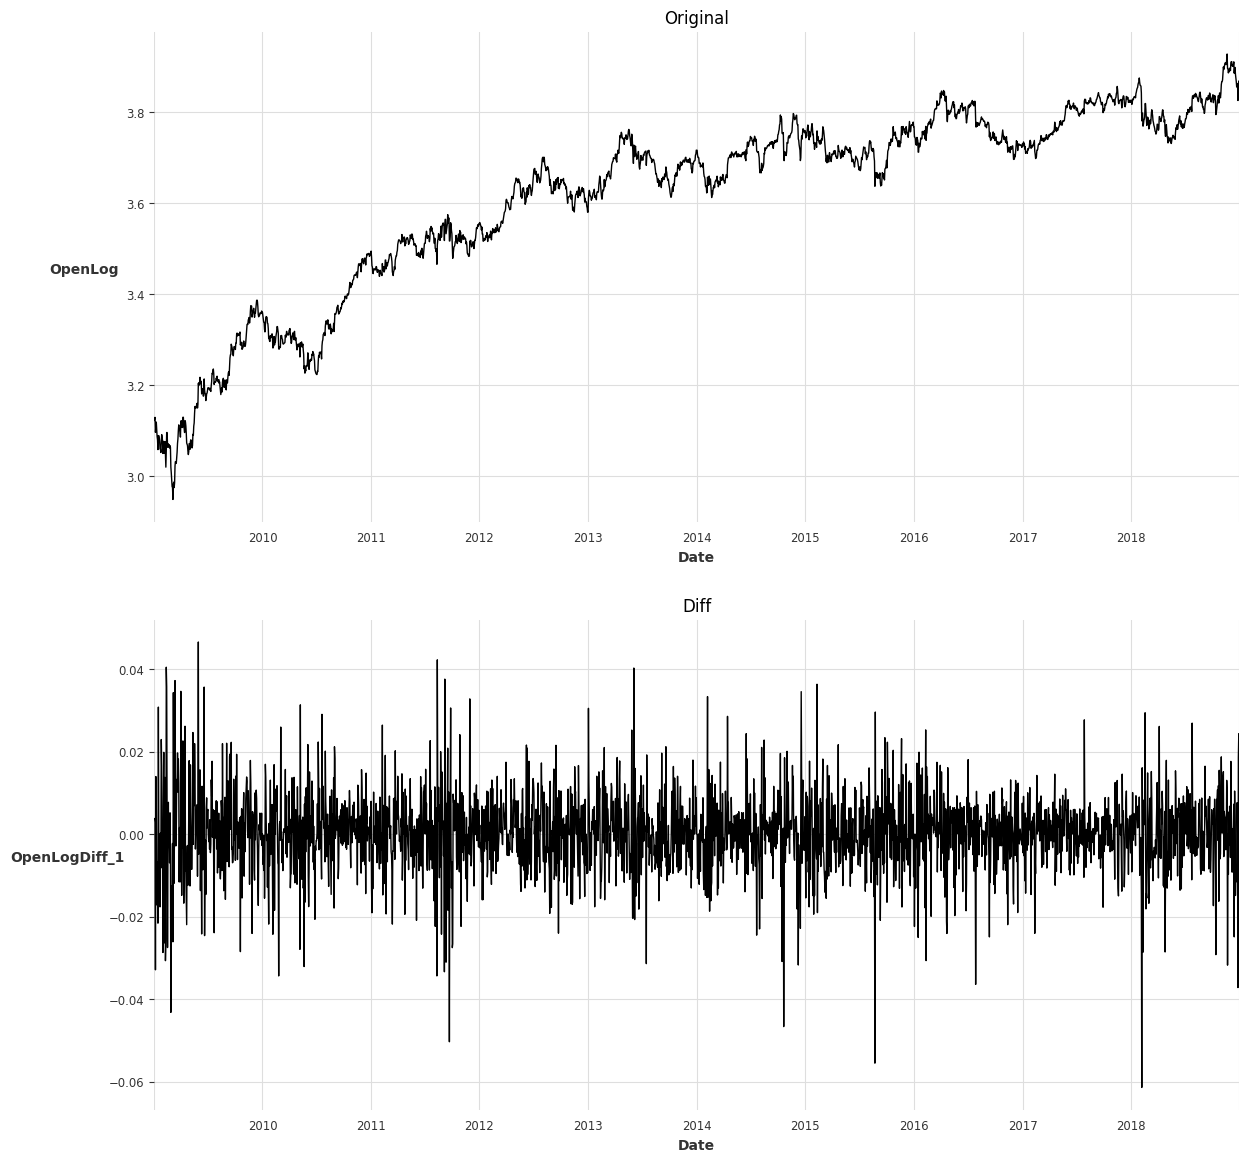

In [363]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('OpenLog', rotation=0, labelpad=30)
df['OpenLog'].plot(ax=ax)

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('OpenLogDiff_1', rotation=0, labelpad=30)
df['OpenLogDiff_1'].plot(ax=ax);

In [364]:
from statsmodels.tsa.stattools import adfuller

_, p_value, *_ = adfuller(df['OpenLogDiff_1'][1:])

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


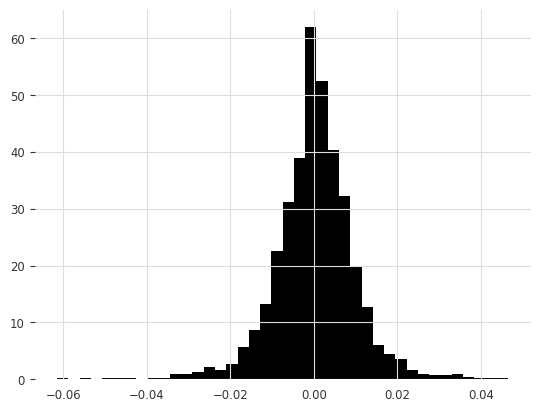

In [365]:
plt.hist(df['OpenLogDiff_1'], density=True, bins=40);

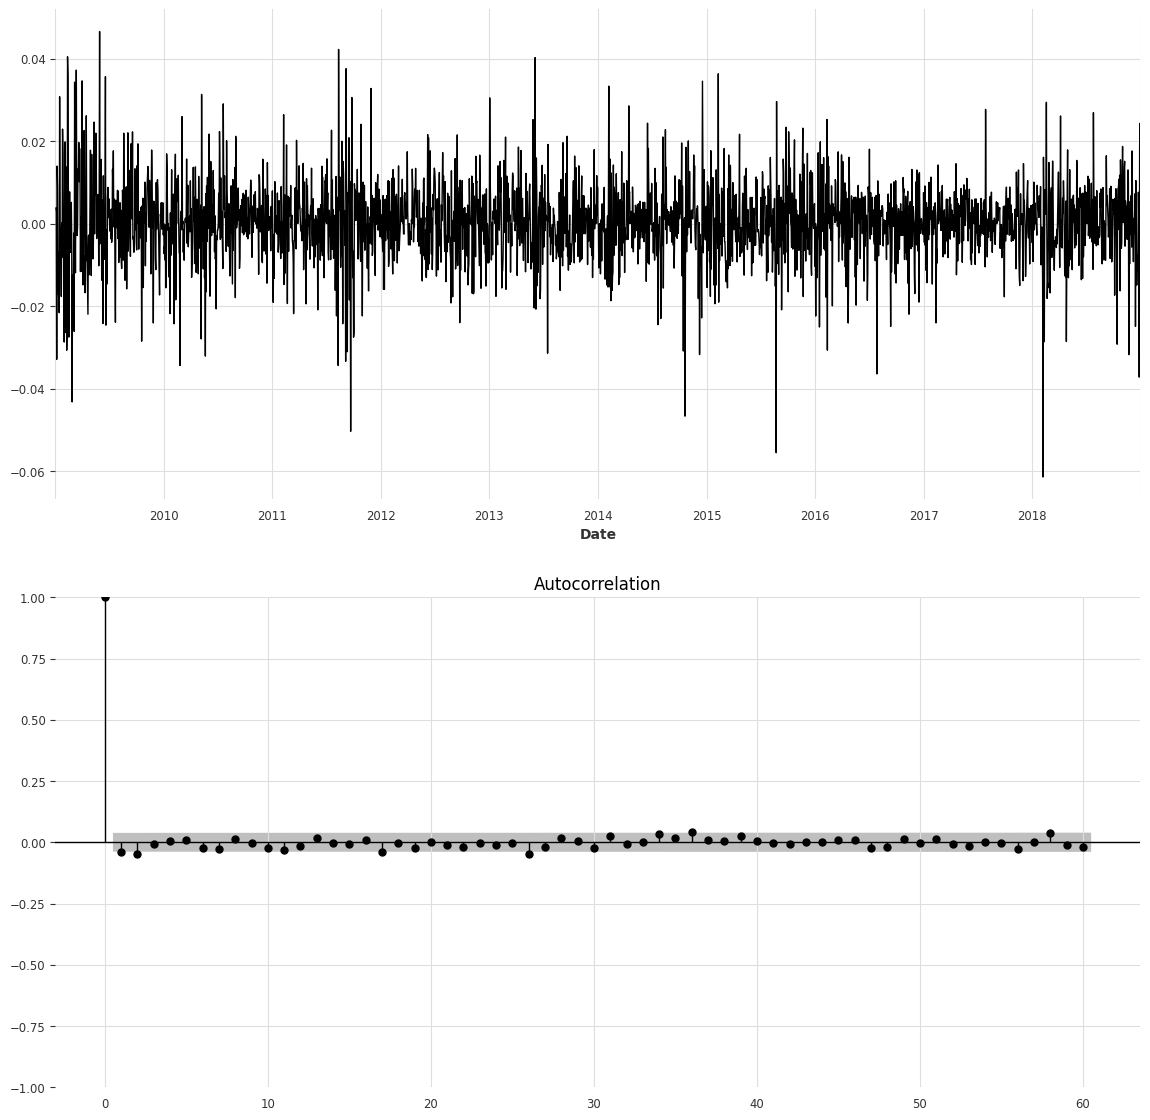

In [366]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(14, 14))

ax = plt.subplot(211)
df['OpenLogDiff_1'].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(df['OpenLogDiff_1'][1:], lags=60, ax=ax);

In [367]:
# Подготовка входных данных

series = pd.Series(df['OpenLog'])

size = int(len(series) * 0.8)
predicted_size = len(series) - size
data_train = series[:size]
data_test = series[size:]

In [368]:
data_train_finish = np.exp(data_train)
data_test_finish = np.exp(data_test)

In [369]:
from darts.utils.utils import SeasonalityMode

# Использование Theta

darts_time_series = TimeSeries.from_series(data_train)
theta_model = Theta(seasonality_period=constants.SEASONALITY_PERIOD, season_mode=SeasonalityMode.ADDITIVE)
theta_model.fit(darts_time_series)
forecast = theta_model.predict(predicted_size)

In [370]:
forecast = np.exp(forecast.pd_series())

In [371]:
# MAPE для Theta

mape_theta = calc_mape(data_test_finish, forecast)
print(f"The MAPE for Theta Model is: {mape_theta}%")

The MAPE for Theta Model is: 4.83%


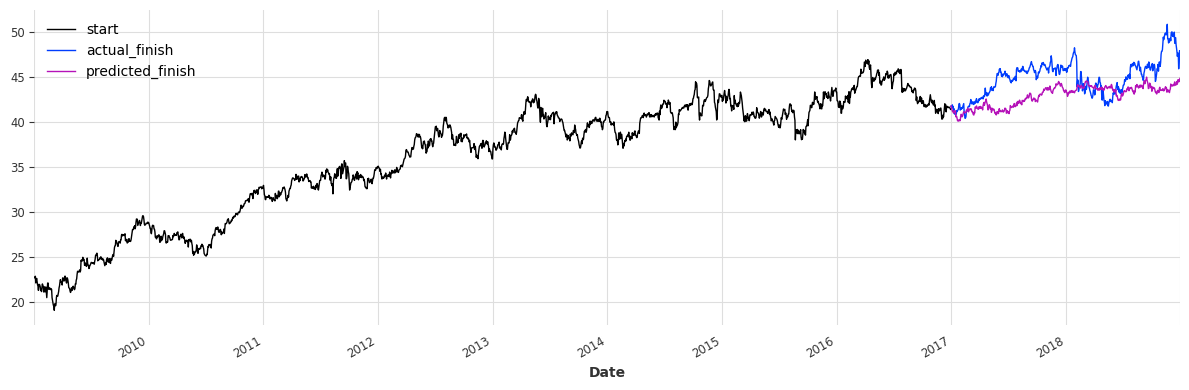

In [372]:
# Предсказание Theta

fig, ax = plt.subplots(figsize=(12, 4))

data_train_finish.plot(ax=ax, label='start')
data_test_finish.plot(ax=ax, label='actual_finish')
forecast.plot(ax=ax, label='predicted_finish')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [373]:
#----------------------------------------------------------------------------------------------------------------

In [374]:
# MyTheta

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.holtwinters as hw


class MyTheta:

    def __init__(
            self,
            period: int,
            theta: int = 2,
    ):
        self.model = "additive"
        self.c = 1
        self.alpha = 1
        self.length = 0
        self.theta = theta
        self.seasonality = None
        self.period = period

    def fit(self, ts: TimeSeries):
        self.length = len(ts)

        my_decompose = seasonal_decompose(ts.pd_series(), self.model, period=self.period)

        self.seasonality = TimeSeries.from_times_and_values(ts.time_index, my_decompose.seasonal)

        ts -= self.seasonality

        self.model = hw.SimpleExpSmoothing(ts.values()).fit()

        self.alpha = self.model.params["smoothing_level"]
        
        self.c = np.polyfit(
            np.array([i for i in range(self.length)]),
            (self.theta - 1) * ts.values(), 1,
        )[0] / self.theta

        return self

    def predict(self, pred_size: int):
        sh_forecast = self.model.forecast(pred_size)   
        
        drift = self.c * np.array(
            [i + 1 / self.alpha - (1 - self.alpha) ** self.length / self.alpha for i in range(pred_size)]
        )

        replicated_seasonality = np.tile(
            self.seasonality.pd_series()[-self.period:],
            (pred_size + self.period - 1) // self.period,
        )[:pred_size]

        sh_forecast += drift + replicated_seasonality
        input_series = TimeSeries.from_series(data_train)
        freq = input_series.freq

        return TimeSeries.from_times_and_values(
            pd.date_range(input_series.end_time() + freq, None, len(sh_forecast), freq),
            sh_forecast,
        )

In [375]:
# Использование MyTheta

darts_time_series = TimeSeries.from_series(data_train)
theta_model = MyTheta(constants.SEASONALITY_PERIOD)
theta_model.fit(darts_time_series)
myForecast = theta_model.predict(predicted_size)

In [376]:
myForecastFinish = np.exp(myForecast.pd_series())

In [377]:
# MAPE для MyTheta

mape_theta = calc_mape(data_test_finish, myForecastFinish)
print(f"The MAPE for MyTheta Model is: {mape_theta}%")

The MAPE for MyTheta Model is: 5.43%


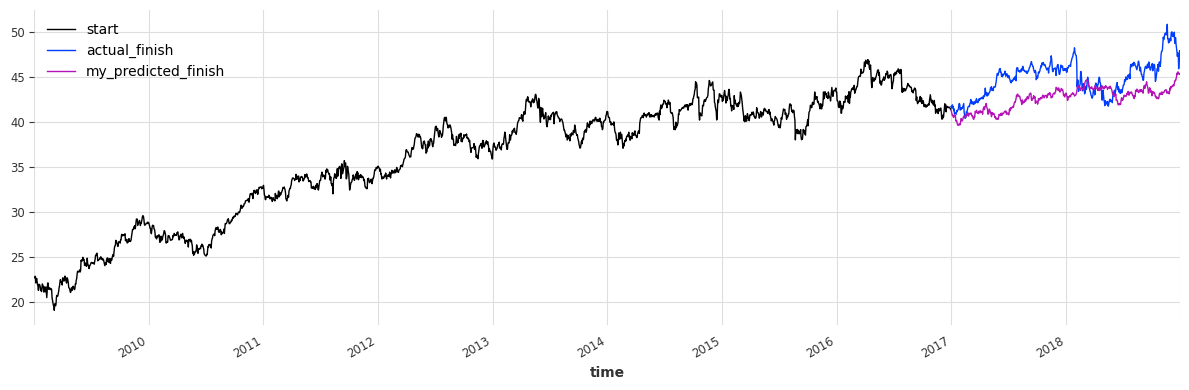

In [378]:
# Предсказание MyTheta

fig, ax = plt.subplots(figsize=(12, 4))

data_train_finish.plot(ax=ax, label='start')
data_test_finish.plot(ax=ax, label='actual_finish')
myForecastFinish.plot(ax=ax, label='my_predicted_finish')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

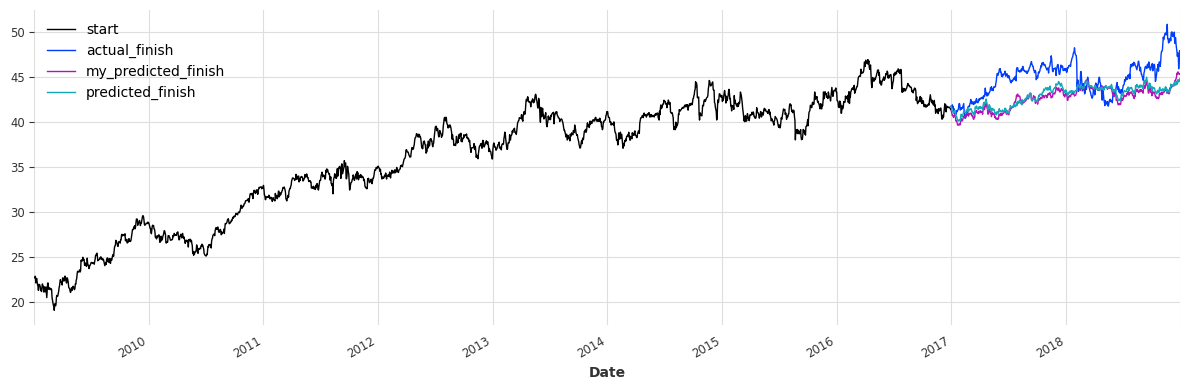

In [379]:
# Оба предсказания на 1 графике

fig, ax = plt.subplots(figsize=(12, 4))
data_train_finish.plot(ax=ax, label='start')
data_test_finish.plot(ax=ax, label='actual_finish')
myForecastFinish.plot(ax=ax, label='my_predicted_finish')
forecast.plot(ax=ax, label='predicted_finish')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()